In [39]:
from NN import SimpleNN
from LR_pt import LogisticRegression
import torch
import os as os
os.chdir("/Users/karl/Desktop/Fairness/algorithmic-fairness-exam")
from data_loader import data_loader, preprocess
from models_clean import one_hot_cols, features
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from fairlearn.metrics import equalized_odds_difference
import matplotlib
from PCA import fair_PCA

In [28]:
one_hot = True

num_samples = 1_000_000
df = data_loader(one_hot_cols, num=num_samples)

# filter columns to only include columns in the features list below
if 'race_ethnicity' in features:
       # remove  'race_ethnicity' from features
       features.remove('race_ethnicity')
else: 
       print("'race_ethnicity' not in features")
x_train, x_val, x_test, y_train,y_val , y_test, train_groups, val_groups,test_groups = preprocess(df, features, one_hot_cols)
print(f'All rows in train_groups sum to 1: {np.allclose(np.sum(train_groups, axis=1), 1)}')

# convert y_train, y_val, y_test to numpy arrays
y_train = y_train.to_numpy()
y_val = y_val.to_numpy()
y_test = y_test.to_numpy()

Loading data...
processed_data.csv exists. Loading data from file.
'race_ethnicity' not in features
x_train: 70.00%
x_val: 15.00%
x_test: 15.00%
Num features BEFORE filtering features 54
Num features AFTER filtering features 14
x_train shape:  (395460, 14)
y_train shape:  (84742, 14)
All rows in train_groups sum to 1: True


In [ ]:
model_path = "models/NN_pca:False_E:20_lr:0.001_bs:512.pt"
num_classes = 2

# Set device
device = torch.device('mps' if torch.cuda.is_available() else 'cpu')
# Initialize the model
model = SimpleNN(x_train.shape[1], num_classes).to(device)

# Load the model
model.load_state_dict(torch.load(model_path))

# Evaluate the model
model.eval()
with torch.no_grad():
    # Get the model predictions
    outputs = model(x_test_tensor)
    
    # Convert the predictions to probabilities using softmax
    probabilities, predicted = torch.max(outputs.data, 1)

    # Compute accuracy
    accuracy = accuracy_score(y_test_tensor.cpu().numpy(), predicted.cpu().numpy())
    
    # Compute F1 score
    f1 = f1_score(y_test_tensor.cpu().numpy(), predicted.cpu().numpy(), average='weighted')
    print(classification_report(y_test_tensor.cpu().numpy(), predicted.cpu().numpy()))


I have this directory fullpath = "/Users/karl/Desktop/Fairness/algorithmic-fairness-exam/models" where the statedict of 5 pytorch models are saved, nothing else. The models that start with "NN" are of the architechture of the imported class SimpleNN, models with the "LRmodel" have the architechture of LogisticRegression. I want a function that load these models into seperate model variable (with suitable names), and returns them. 

In [55]:
def load_models(input_size, num_classes, models_directory):
    models = {}

    for filename in os.listdir(models_directory):
        if filename.endswith('.pt'):  # if the file is a PyTorch model
            full_path = os.path.join(models_directory, filename)
            state_dict = torch.load(full_path)

            if filename.startswith('NN'):
                model_name = "NN"
                if "pca:True" in filename:
                    model = SimpleNN(9, num_classes)  
                    model_name += "_FairPCA"
                else:
                    model = SimpleNN(input_size, num_classes)  
            elif filename.startswith('LRmodel'):
                model = LogisticRegression(input_size)
                model_name = "LR"
                if "F:NO l2" in filename:
                    model_name += "_L2"
                elif "F:True" in filename:
                    model_name += "_FairLoss"

            model.load_state_dict(state_dict)
            models[model_name] = model

    return models


In [56]:
models = load_models(x_train.shape[1], 2, '/Users/karl/Desktop/Fairness/algorithmic-fairness-exam/old_models')
print(models['LR'])  



LogisticRegression(
  (linear): Linear(in_features=14, out_features=1, bias=True)
)


In [57]:
def evaluate_models(models, x_train, x_test, y_test, test_groups):
    plt.style.use('bmh')
    matplotlib.rcParams['font.family'] = 'STIXGeneral'
    # list of metric names
    metric_names = ['weighted_f1', 'f1_score_0', 'f1_score_1', 'mean_equalized_odds_difference']

    # dictionary to hold metric values for each model
    metric_values = {name: [] for name in metric_names}

    for model_name, model in models.items():
        print()
        print(f'Evaluating {model_name}...')
        print("_____________________________\n")
        if model_name == 'NN_FairPCA':
            X_fair_PCA, U, explained_variance = fair_PCA(x_train, n_components=x_train.shape[1], groups=train_groups)
            x_train = X_fair_PCA
            x_test_pca = x_test @ U

        # get model predictions
        if model_name.startswith('NN'):
            # argmax of softmax output is the predicted class
            if model_name == 'NN_FairPCA':
                test_preds = model(x_test_pca).detach().numpy().argmax(axis=1)
            else:
                test_preds = model(x_test).detach().numpy().argmax(axis=1)
        else:
            # logistic regression outputs probabilities
            test_preds = model(x_test).detach().numpy() > 0.5
        print(test_preds[:10])
        # calculate weighted f1 score
        weighted_f1 = f1_score(y_test, test_preds, average='weighted')
        metric_values['weighted_f1'].append(weighted_f1)

        # calculate f1 score for class 0
        f1_score_0 = f1_score(y_test, test_preds, pos_label=0)
        metric_values['f1_score_0'].append(f1_score_0)

        # calculate f1 score for class 1
        f1_score_1 = f1_score(y_test, test_preds, pos_label=1)
        metric_values['f1_score_1'].append(f1_score_1)

        # calculate mean equalized odds difference
        one_hot_cols = list(range(6))
        mean_eod = np.mean([
            equalized_odds_difference(y_test, test_preds, sensitive_features=test_groups[:, one_hot_cols.index(col)])
            for col in one_hot_cols
        ])
        metric_values['mean_equalized_odds_difference'].append(mean_eod)
        print(f'Weighted F1: {weighted_f1:.4f}')
        print(f'F1 score (class 0): {f1_score_0:.4f}')
        print(f'F1 score (class 1): {f1_score_1:.4f}')
        print(f'Mean equalized odds difference: {mean_eod:.4f}')
    
    # create bar chart
    x = np.arange(len(metric_names))  # the label locations
    width = 0.2  # the width of the bars

    fig, ax = plt.subplots()
    for i, model_name in enumerate(models.keys()):
        ax.bar(x - width/2 + i*width, metric_values[model_name], width, label=model_name)

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Scores')
    ax.set_title('Scores by model and metric')
    ax.set_xticks(x)
    ax.set_xticklabels(metric_names)
    ax.legend()

    plt.show()

In [58]:
def evaluate_models(models, x_train, x_test, y_test, test_groups):
    plt.style.use('bmh')
    matplotlib.rcParams['font.family'] = 'STIXGeneral'
    # list of metric names
    metric_names = ['weighted_f1', 'f1_score_0', 'f1_score_1', 'mean_equalized_odds_difference']

    # dictionary to hold metric values for each model
    metric_values = {model_name: {metric: None for metric in metric_names} for model_name in models.keys()}

    for model_name, model in models.items():
        print()
        print(f'Evaluating {model_name}...')
        print("_____________________________\n")
        if model_name == 'NN_FairPCA':
            X_fair_PCA, U, explained_variance = fair_PCA(x_train, n_components=x_train.shape[1], groups=train_groups)
            x_train = X_fair_PCA
            x_test_pca = x_test @ U

        # get model predictions
        if model_name.startswith('NN'):
            # argmax of softmax output is the predicted class
            if model_name == 'NN_FairPCA':
                test_preds = model(x_test_pca).detach().numpy().argmax(axis=1)
            else:
                test_preds = model(x_test).detach().numpy().argmax(axis=1)
        else:
            # logistic regression outputs probabilities
            test_preds = model(x_test).detach().numpy() > 0.5
        # calculate weighted f1 score
        weighted_f1 = f1_score(y_test, test_preds, average='weighted')

        # calculate f1 score for class 0
        f1_score_0 = f1_score(y_test, test_preds, pos_label=0)

        # calculate f1 score for class 1
        f1_score_1 = f1_score(y_test, test_preds, pos_label=1)

        # calculate mean equalized odds difference
        one_hot_cols = list(range(6))
        mean_eod = np.mean([
            equalized_odds_difference(y_test, test_preds, sensitive_features=test_groups[:, one_hot_cols.index(col)])
            for col in one_hot_cols
        ])

        # calculate weighted f1 score and other metrics
        metric_values[model_name]['weighted_f1'] = weighted_f1
        metric_values[model_name]['f1_score_0'] = f1_score_0
        metric_values[model_name]['f1_score_1'] = f1_score_1
        metric_values[model_name]['mean_equalized_odds_difference'] = mean_eod
        print(f'Weighted F1: {weighted_f1:.4f}')
        print(f'F1 score (class 0): {f1_score_0:.4f}')
        print(f'F1 score (class 1): {f1_score_1:.4f}')
        print(f'Mean equalized odds difference: {mean_eod:.4f}')

    # create bar chart
    x = np.arange(len(metric_names))  # the label locations
    width = 0.2  # the width of the bars

    fig, ax = plt.subplots()
    for i, model_name in enumerate(models.keys()):
        scores = [metric_values[model_name][metric] for metric in metric_names]
        ax.bar(x - width/2 + i*width, scores, width, label=model_name)

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Scores')
    ax.set_title('Scores by model and metric')
    ax.set_xticks(x)
    ax.set_xticklabels(metric_names)
    ax.legend()

    plt.show()



Evaluating LR_L2...
_____________________________

Weighted F1: 0.7397
F1 score (class 0): 0.2662
F1 score (class 1): 0.8625
Mean equalized odds difference: 0.1251

Evaluating NN_FairPCA...
_____________________________

Weighted F1: 0.8285
F1 score (class 0): 0.5251
F1 score (class 1): 0.9072
Mean equalized odds difference: 0.0973

Evaluating LR...
_____________________________

Weighted F1: 0.7521
F1 score (class 0): 0.3509
F1 score (class 1): 0.8562
Mean equalized odds difference: 0.0389

Evaluating LR_FairLoss...
_____________________________

Weighted F1: 0.7557
F1 score (class 0): 0.3332
F1 score (class 1): 0.8653
Mean equalized odds difference: 0.0827

Evaluating NN...
_____________________________

Weighted F1: 0.8612
F1 score (class 0): 0.6454
F1 score (class 1): 0.9172
Mean equalized odds difference: 0.1575


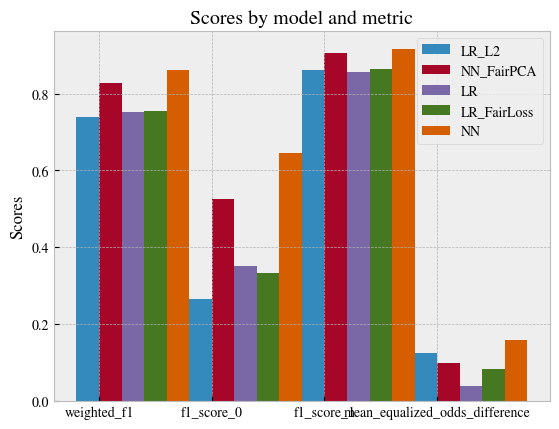

x_test:  <class 'numpy.ndarray'>
y_test:  <class 'numpy.ndarray'>


In [59]:
evaluate_models(models, x_train, x_test, y_test, test_groups)
# print types of parameters
print("x_test: ", type(x_test))
print("y_test: ", type(y_test))